In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
%matplotlib inline

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, thickness=15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #These variables are used to recall th last calcualted lane position if the
    #the lane finding pipe line fails frame count and frame drop are used to understand 
    #quality of whole pipeline
    global lineslast #stores last calculated line position
    global frameCount #counts number of frames in image
    global frameDrop #counts number of frames where pipeline failed
    
    leftLineCount=0
    rightLineCount=0
    leftSum=np.zeros(4)
    rightSum=np.zeros(4)
    leftLength = 0
    rightLength = 0
    #frame count only set for video analysis
    try:
        frameCount=frameCount+1
    except:
        next
    
    #analyse all lines found through hough transform
    for line in lines:
        for x1,y1,x2,y2 in line:
            #find line gradient - we're only interested in lines angled 
            #towards teh centre of the image
            m=(y2-y1)/(x2-x1)
            #if the line has a negative gradient then the line is on the left side of the image
            if m < - 0.4 and m > -0.8:
                #find the length of the lines - the side with the longest continuos line
                #is a solid line - the side with the shorter line is the dashed lane line
                lineLength=math.sqrt(math.pow((y2-y1),2)+math.pow((x2-x1),2))
                if lineLength > leftLength:
                    leftLength = lineLength
                leftSum=np.add(leftSum,line)
                leftLineCount+=1
            
            #if the line has a positive gradient then the line is on the    right side of
            #the image
                    
            elif m > 0.4 and m < 0.8:
                #find the length of the longest line on the irght hand side
                lineLength=math.sqrt(math.pow((y2-y1),2)+math.pow((x2-x1),2))
                if lineLength > rightLength:
                    rightLength = lineLength
                rightSum=np.add(rightSum,line)
                rightLineCount+=1
                
    #if there have been enough lines found in the image then we can find
    #the average position of the left and right hand lines
    try:
        leftAverage=np.zeros(4)            
        leftAverage[0]=(leftSum[0,0]/leftLineCount)
        leftAverage[1]=(leftSum[0,1]/leftLineCount)
        leftAverage[2]=(leftSum[0,2]/leftLineCount)
        leftAverage[3]=(leftSum[0,3]/leftLineCount)

        rightAverage=np.zeros(4)
        rightAverage[0]=(rightSum[0,0]/rightLineCount)
        rightAverage[1]=(rightSum[0,1]/rightLineCount)
        rightAverage[2]=(rightSum[0,2]/rightLineCount)
        rightAverage[3]=(rightSum[0,3]/rightLineCount)

        #find left average gradient and intersection then interpolate lines for display
        mskVert=75
        leftM=(leftAverage[3]-leftAverage[1])/(leftAverage[2]-leftAverage[0])
        leftB=leftAverage[1]-(leftM*leftAverage[0])
        leftLines=np.zeros((4),dtype=np.int)

        leftLines[1]=int(img.shape[0]/2+mskVert)
        leftLines[0]=int((leftLines[1]-leftB)/leftM)
        leftLines[3]=int(img.shape[0])
        leftLines[2]=int((leftLines[3]-leftB)/leftM)
        
        #find right average gradient and intersection then interpolate lines for display
        rightM=(rightAverage[3]-rightAverage[1])/(rightAverage[2]-rightAverage[0])
        rightB=rightAverage[1]-(rightM*rightAverage[0])
        rightLines=np.zeros((4),dtype=np.int)

        rightLines[1]=int(img.shape[0]/2+mskVert)
        rightLines[0]=int((rightLines[1]-rightB)/rightM)
        rightLines[3]=int(img.shape[0])
        rightLines[2]=int((rightLines[3]-rightB)/rightM)
        #if the left line is longer then it is a solid line a car can
        #not cross this line so colour red
        #that means the other side is made from dashed lines - a car can cross 
        #dashed lines so make green
        if leftLength > rightLength:
            leftColor=[255,0,0]
            rightColor=[0,255,0]
            colorFlag=0
        #if lane lengths are opposite then colour otherway around
        else:
            leftColor=[0,255,0]
            rightColor=[255,0,0]
            colorFlag=1
        #draw lines on image
        cv2.line(img, (leftLines[0], leftLines[1]), (leftLines[2], leftLines[3]), leftColor, thickness)
        cv2.line(img, (rightLines[0], rightLines[1]), (rightLines[2], rightLines[3]), rightColor, thickness)
        #for video to store last recorded lane line positions
        try:
            lineslast[0]=leftLines[0]
            lineslast[1]=leftLines[1]
            lineslast[2]=leftLines[2]
            lineslast[3]=leftLines[3]
            lineslast[4]=rightLines[0]
            lineslast[5]=rightLines[1]
            lineslast[6]=rightLines[2]
            lineslast[7]=rightLines[3]
            lineslast[8]=colorFlag
        except:
            next
    except:
        #if prior code block has not run then their has been a failure in the lane finding process
        #error rate recorded with frameDrop variable
        try:
            frameDrop=frameDrop+1
        except:
            next
        #draw lines on iumage with last known lane data
        if lineslast[8]==1:
            cv2.line(img, (lineslast[0], lineslast[1]), (lineslast[2], lineslast[3]), [0,255,0], thickness)
            cv2.line(img, (lineslast[4], lineslast[5]), (lineslast[6], lineslast[7]), [255,0,0], thickness)
        else:
            cv2.line(img, (lineslast[0], lineslast[1]), (lineslast[2], lineslast[3]), [255,0,0], thickness)
            cv2.line(img, (lineslast[4], lineslast[5]), (lineslast[6], lineslast[7]), [0,255,0], thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img,lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.5, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [3]:
kernel=5 #kernel dim for gaussian blur
blurAction= lambda image: gaussian_blur(image,kernel)

In [4]:
grayAction = lambda image: grayscale(image)

In [5]:
cannyLo = 50 #lower canny threshold value
cannyHi = 150 #upper canny threshold value
edgeAction = lambda image: canny(image, cannyLo, cannyHi)

In [6]:
mskVert=50 # mask offset from image centre in y
mskHorz=15 # upper mask offset from image centre in x
mskLwrHorz=70 # lower mask offset from image in x
maskAction = lambda image: region_of_interest(image,np.array([[(mskLwrHorz,image.shape[0]),((image.shape[1]/2)-mskHorz, (image.shape[0]/2)+mskVert), ((image.shape[1]/2)+mskHorz, (image.shape[0]/2)+mskVert), (image.shape[1]-mskLwrHorz,image.shape[0])]], dtype=np.int32)
)

In [7]:
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
hoThresh = 70     # minimum number of votes (intersections in Hough grid cell)
hoMinLin = 3 #minimum number of pixels making up a line
hoMaxGap = 20    # maximum gap in pixels between connectable line segments
houghAction = lambda image: hough_lines(image,rho, theta, hoThresh, hoMinLin, hoMaxGap)

In [8]:
outputImageAction= lambda imageS: weighted_img(imageS[0],imageS[1])#, α=0.8, β=1., λ=0.5)

In [9]:
#image processing pipeline
def procImage(image):
    return outputImageAction([image,houghAction(maskAction(edgeAction(blurAction(grayAction(image)))))])

solidWhiteRight.jpg


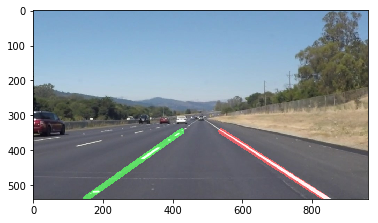

solidYellowLeft.jpg


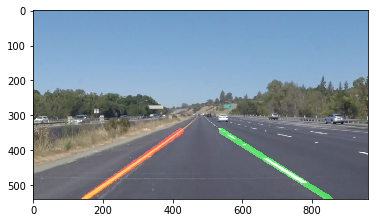

whiteCarLaneSwitch.jpg


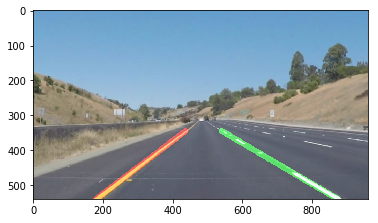

solidYellowCurve2.jpg


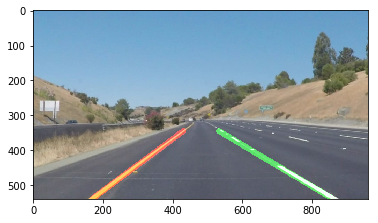

solidYellowCurve.jpg


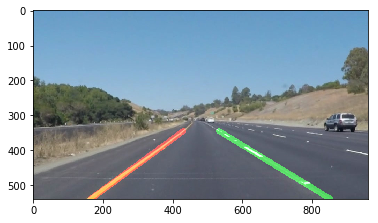

solidWhiteCurve.jpg


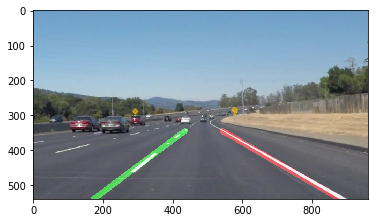

In [15]:
#image analysis script
for image in os.listdir("test_images/"):
    #reading in an image
    print (image)
    filePath="test_images/"+image
    lineView=procImage(mpimg.imread(filePath))
    filePathOut='test_images_output/'+image
    plt.imshow(lineView)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    plt.savefig(filePathOut)
    plt.show()

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
for video in os.listdir("test_videos/"):
    #load video from file
    #set variables to ensure dropped frames are not a problem
    global lineslast
    global frameCount
    global frameDrop
    lineslast=np.zeros((9),dtype=np.int)
    frameCount=0
    frameDrop=0
    #reading video
    print (video)
    filePath="test_videos/"+video
    white_output = 'test_videos_output/'+str(video)
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip = VideoFileClip(filePath)
    white_clip = clip.fl_image(procImage) #NOTE: this function expects color images!!
    white_clip.write_videofile(white_output, audio=False)
    analysisQuality=int((frameDrop/frameCount)*100)
    print("Analysis Quality frame drop % =", analysisQuality)

challenge.mp4
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:22<00:00, 12.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Analysis Quality frame drop % = 28
solidYellowLeft.mp4
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:26<00:00, 25.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Analysis Quality frame drop % = 23
solidWhiteRight.mp4
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:08<00:00, 27.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Analysis Quality frame drop % = 30
